# Importação de Libs e carregamento dos dados

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle



from sklearn.pipeline import Pipeline
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.pipeline import Pipeline



In [95]:
data = pd.read_csv('./datasets/Churn.csv')

## Análise da qualidade dos dados

In [97]:
data.head()

In [98]:
data.info()

In [99]:
# Verificar se há valores duplicados
data.duplicated().sum()

In [100]:
(data
 .Tenure
 .isnull()
 .value_counts()
 )


In [101]:
# Deletar linhas que contenham NaN
data_nan = data.dropna(subset=['Tenure'])

In [102]:
# Excluir colunas que não serão necessárias
data_cleaned = data_nan.drop(columns=['RowNumber','CustomerId','Surname'])
display(data_cleaned.head())
print(data_cleaned.shape)

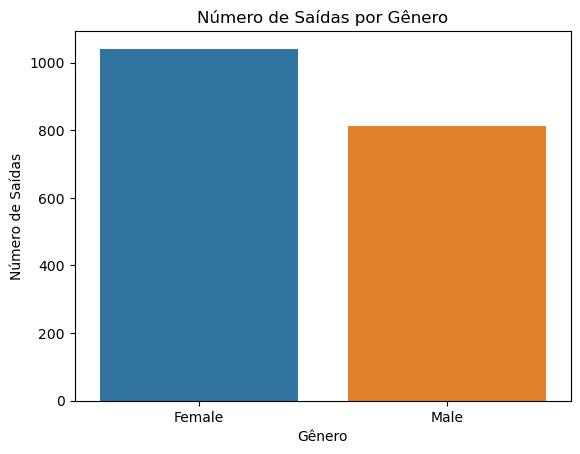

In [103]:
exited_gender = data_cleaned.groupby('Gender')['Exited'].sum()
sns.barplot(x=exited_gender.index, y=exited_gender.values)
plt.title('Número de Saídas por Gênero')
plt.xlabel('Gênero')
plt.ylabel('Número de Saídas')
plt.show()

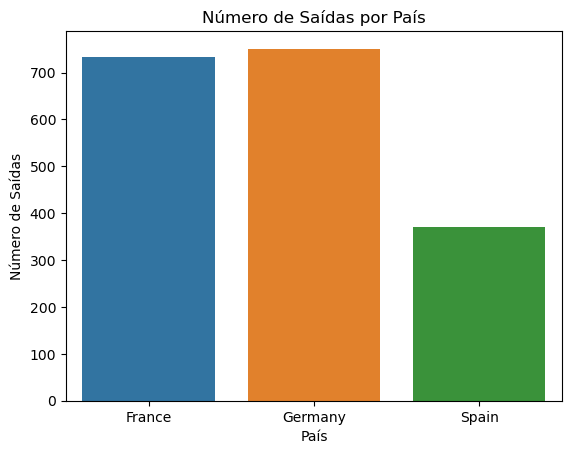

In [104]:
exited_countries = data_cleaned.groupby('Geography')['Exited'].sum()
sns.barplot(x=exited_countries.index, y=exited_countries.values)
plt.title('Número de Saídas por País')
plt.xlabel('País')
plt.ylabel('Número de Saídas')
plt.show()

In [105]:
# Verificando o peso das classes

(data_cleaned
 .Exited
 .value_counts()

 )

As classes estão desbalanceadas, sendo que os clientes que saíram do banco corespondem a aproximadamente 20% do dados analisados.

## Processando os dados: Utilizando o pd.get_dummies para transformar as categorias Gender e Geography em números para possibilitar sua utilização nos modelos.

In [108]:
data_cleaned.head(2)
data_cleaned = pd.get_dummies(data_cleaned, dtype='int')
data_cleaned

In [109]:
X = data_cleaned.drop(columns=['Exited'], axis=1)
y = data_cleaned['Exited']

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### Modelos

#### Logistic Regression 

In [113]:
lr = LogisticRegression(solver = 'liblinear', max_iter=100, random_state=42, penalty='l1')
lr.fit(X_train, y_train)

In [114]:
lr_pred = lr.predict(X_test)
lr_acc = accuracy_score(y_test, lr_pred)
lr_f1 = f1_score(y_test, lr_pred)
lr_roc = roc_auc_score(y_test, lr_pred)

print(f'Accuracy:{lr_acc}, F1:{lr_f1}, ROC:{lr_roc}.')

#### Random Forest Classifier

In [116]:
# rf = RandomForestClassifier(max_depth=10, min_samples_leaf=1, min_samples_split=2, 
#                             n_estimators=100, random_state=45, class_weight=None)
# rf.fit(X_train, y_train)

In [117]:
# rf_predicted = rf.predict(X_test)
# rf_acc = accuracy_score(y_test, rf_predicted)
# rf_f1 = f1_score(y_test, rf_predicted)
# rf_roc = roc_auc_score(y_test, rf_predicted)
# print(f'Accuracy: {rf_acc}, f1_Score: {rf_f1}, ROC: {rf_roc}')

In [176]:
rf = RandomForestClassifier()
n_estimators=[50, 100]
max_depth=[1, 3, 5]
max_features=[3, 5, 10]
criterion = ['gini', 'entropy']
min_samples_split = [2, 5, 10]


grid=dict(n_estimators=n_estimators, max_depth=max_depth, max_features=max_features, criterion=criterion, min_samples_split = min_samples_split)
grid_search = GridSearchCV(estimator = rf, param_grid=grid, scoring='f1')
result = grid_search.fit(X_train, y_train)
print("Best Parameters:", result.best_params_)
print("Best Score:", result.best_score_)
best_rf = result.best_estimator_

In [178]:
rf_predicted = best_rf.predict(X_test)
rf_acc = accuracy_score(y_test, rf_predicted)
rf_f1 = f1_score(y_test, rf_predicted)
rf_roc = roc_auc_score(y_test, rf_predicted)
print(f'Accuracy: {rf_acc}, f1_Score: {rf_f1}, ROC: {rf_roc}')

#### Decision Tree Classifier

In [123]:
# dt = DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=10, min_samples_leaf=1, min_samples_split=2,random_state=42, splitter='best')
# # dt= DecisionTreeClassifier(max_depth=None , criterion='gini', min_samples_split=2, min_samples_leaf=1)
# dt.fit(X_train, y_train)

In [124]:
# dt_predicted = dt.predict(X_test)
# dt_acc = accuracy_score(y_test, dt_predicted)
# dt_f1 = f1_score(y_test, dt_predicted)
# dt_roc = roc_auc_score(y_test, dt_predicted)

# print(f'Accuracy: {dt_acc}, f1_score: {dt_f1}, ROC: {dt_roc}.')


In [128]:
dt = DecisionTreeClassifier()
criterion=['gini', 'entropy']
max_depth=[1, 3, 5]

grid=dict(criterion=criterion, max_depth=max_depth)
grid_search = GridSearchCV(estimator = dt, param_grid=grid, scoring='f1')
result = grid_search.fit(X_train, y_train)
print("Best Parameters:", result.best_params_)
print("Best Score:", result.best_score_)
best_dt = result.best_estimator_

In [129]:
dt_predicted = best_dt.predict(X_test)
dt_acc = accuracy_score(y_test, dt_predicted)
dt_f1 = f1_score(y_test, dt_predicted)
dt_roc = roc_auc_score(y_test, dt_predicted)

print(f'Accuracy: {dt_acc}, f1_score: {dt_f1}, ROC: {dt_roc}.')

## Alterações para melhorar o score
Buscando melhores resultados, foram feitos ajustes e testes com diferentes parâmetros, obtendo, ao final, resultado um pouco melhor.


### 'Balanced' 

#### Logistic Regression

In [133]:
lr2 = LogisticRegression(class_weight='balanced', solver = 'liblinear', max_iter=100, random_state=42, penalty='l1')
lr2.fit(X_train, y_train)

In [134]:
lr2_pred = lr2.predict(X_test) 
lr2_acc = accuracy_score(y_test, lr2_pred)
lr2_f1 = f1_score(y_test, lr2_pred)
lr2_roc = roc_auc_score(y_test, lr2_pred)

print(f'Accuracy: {lr2_acc}, F1: {lr2_f1}, ROC: {lr2_roc}.')

#### Random Forest Classifier

In [136]:
# rf2 = RandomForestClassifier(max_depth=10, n_estimators=100,
#                              criterion='entropy', random_state=42,
#                              min_samples_split=2, class_weight= 'balanced')
# rf2.fit(X_train, y_train)
# rf2_predicted = rf2.predict(X_test)
# rf2_acc = accuracy_score(y_test, rf2_predicted)
# rf2_f1 = f1_score(y_test, rf2_predicted)
# rf2_roc = roc_auc_score(y_test, rf2_predicted)
# print(f'Accuracy: {rf2_acc}, f1_Score: {rf2_f1}, ROC:{rf2_roc}')

In [172]:
rf2 = RandomForestClassifier()
n_estimators=[50, 100]
max_depth=[1, 3, 5]
max_features = [3, 5, 10]
criterion = ['gini', 'entropy']
min_samples_split = [2, 5, 10]
class_weight = ['balanced']

grid=dict(n_estimators=n_estimators, max_depth=max_depth, max_features=max_features, criterion=criterion, min_samples_split= min_samples_split, class_weight=class_weight)
grid_search = GridSearchCV(estimator = rf2, param_grid=grid, scoring='f1')
result = grid_search.fit(X_train, y_train)
print("Best Parameters:", result.best_params_)
print("Best Score:", result.best_score_)
best_rf2 = result.best_estimator_

In [174]:
rf2_predicted = best_rf2.predict(X_test)
rf2_acc = accuracy_score(y_test, rf2_predicted)
rf2_f1 = f1_score(y_test, rf2_predicted)
rf2_roc = roc_auc_score(y_test, rf2_predicted)
print(f'Accuracy: {rf2_acc}, f1_Score: {rf2_f1}, ROC: {rf2_roc}')

#### Decision Tree Classifier


In [63]:
dt2 = DecisionTreeClassifier()
criterion=['gini', 'entropy']
max_depth=[1, 3, 5]

grid=dict(criterion=criterion, max_depth=max_depth)
grid_search = GridSearchCV(estimator = dt2, param_grid=grid, scoring='f1')
result = grid_search.fit(X_train, y_train)
print("Best Parameters:", result.best_params_)
print("Best Score:", result.best_score_)
best_dt2 = result.best_estimator_

In [64]:
dt2_predicted = best_dt2.predict(X_test)
dt2_acc = accuracy_score(y_test, dt2_predicted)
dt2_f1 = f1_score(y_test, dt2_predicted)
dt2_roc = roc_auc_score(y_test, dt2_predicted)

print(f'Accuracy: {dt2_acc}, f1_score: {dt2_f1}, ROC: {dt2_roc}.')

### Upsampling

In [66]:
X = data_cleaned.drop('Exited', axis = 1)
y = data_cleaned['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=12345)


def upsample(X, y, repeat):
    X_zeros = X[y == 0]
    X_ones = X[y == 1]
    y_zeros = y[y == 0]
    y_ones = y[y == 1]

    X_upsampled = pd.concat([X_zeros] + [X_ones] * repeat)
    y_upsampled = pd.concat([y_zeros] + [y_ones] * repeat)

    X_upsampled, y_upsampled = shuffle(
        X_upsampled, y_upsampled, random_state=12345
    )

    return X_upsampled, y_upsampled


X_upsampled, y_upsampled = upsample(
    X_train, y_train, 30
)


#### Logistic Regression Upsampled


In [68]:
lr_up = LogisticRegression(class_weight='balanced', solver = 'liblinear', max_iter=100, random_state=42, penalty='l1')
lr_up.fit(X_upsampled, y_upsampled)

lr_up_pred= lr_up.predict(X_test)

lr_up_accuracy = accuracy_score(y_test, lr_up_pred)
lr_up_f1 = f1_score(y_test, lr_up_pred)
lr_up_roc = roc_auc_score(y_test, lr_up_pred)

print(f'Accuracy: {lr_up_accuracy}, F1: {lr_up_f1}, ROC: {lr_up_roc}.')

#### Random Forest Classifier Upsampled

In [70]:
# rf_up = RandomForestClassifier(max_depth=10, n_estimators=100
#                             , criterion='entropy', random_state=42,
#                             min_samples_split=10, min_samples_leaf=1, class_weight= 'balanced')

In [71]:
# rf_up.fit(X_upsampled, y_upsampled)
# rf_up_pred = rf_up.predict(X_test)

In [72]:
# rf_up_acc = accuracy_score(y_test, rf_up_pred)
# rf_up_f1 = f1_score(y_test, rf_up_pred)
# rf_up_roc = roc_auc_score(y_test, rf_up_pred)
# print(f'Accuracy: {rf_up_acc}, F1_score: {rf_up_f1}, ROC: {rf_up_roc}.')

In [196]:
rf_up = RandomForestClassifier()
n_estimators=[50, 100]
max_depth=[1, 3, 5, 10]
criterion = ['gini', 'entropy']
min_samples_split = [2, 5, 10]
class_weight = ['balanced']


grid=dict(n_estimators=n_estimators, max_depth=max_depth, criterion=criterion, min_samples_split= min_samples_split, class_weight=class_weight)
grid_search = GridSearchCV(estimator = rf_up, param_grid=grid, scoring='f1')
result = grid_search.fit(X_upsampled, y_upsampled)
print("Best Parameters:", result.best_params_)
print("Best Score:", result.best_score_)
best_rf_up = result.best_estimator_

In [198]:
rf_up_pred = best_rf_up.predict(X_test)
rf_up_acc = accuracy_score(y_test, rf_up_pred)
rf_up_f1 = f1_score(y_test, rf_up_pred)
rf_up_roc = roc_auc_score(y_test, rf_up_pred)
print(f'Accuracy: {rf_up_acc}, F1_score: {rf_up_f1}, ROC: {rf_up_roc}.')

#### Decision Tree Classifier Upsampled

In [184]:
dt_up = DecisionTreeClassifier()
criterion=['gini', 'entropy']
max_depth=[1, 3, 5, 10]

grid=dict(criterion=criterion, max_depth=max_depth)
grid_search = GridSearchCV(estimator = dt2, param_grid=grid, scoring='f1')
result = grid_search.fit(X_train, y_train)
print("Best Parameters:", result.best_params_)
print("Best Score:", result.best_score_)
best_dt_up = result.best_estimator_

In [186]:
dt_up_pred = best_dt_up.predict(X_test)
dt_up_acc = accuracy_score(y_test, dt_up_pred)
dt_up_f1 = f1_score(y_test, dt_up_pred)
dt_up_roc = roc_auc_score(y_test, dt_up_pred)

print(f'Accuracy: {dt_up_acc}, F1_score: {dt_up_f1}, ROC: {dt_up_roc}.')

### Gráficos comparativos dos resultados

In [202]:
modelos = ['Logistic Regression', 'Decision Tree', 'Random Forest']
f1_scores_sets = [
    [lr_f1, dt_f1, rf_f1],
    [lr2_f1, dt2_f1, rf2_f1],
    [lr_up_f1, dt_up_f1, rf_up_f1]
]
titles = [
    'Comparação de F1 Scores entre Modelos',
    'Comparação de F1 Scores entre Modelos - Balanced',
    'Comparação de F1 Scores entre Modelos - Upsampling'
]


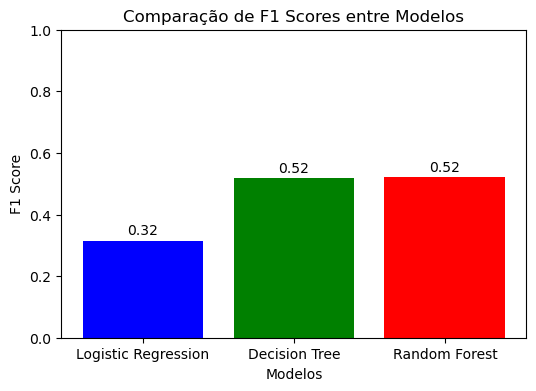

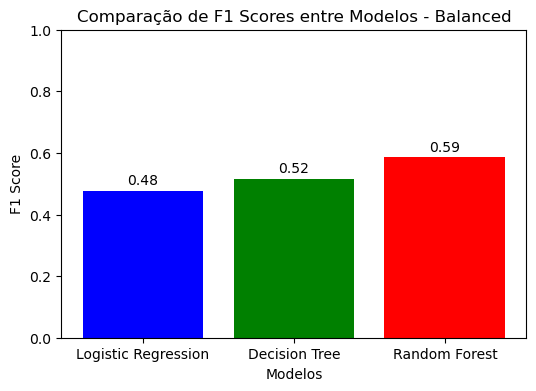

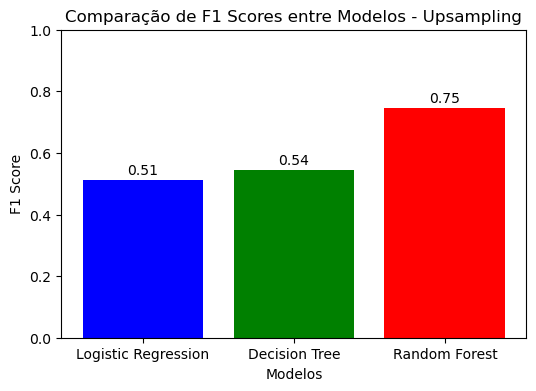

In [204]:
def plot_f1_scores(modelos, f1_scores, title):
    plt.figure(figsize=(6, 4))
    bars = plt.bar(modelos, f1_scores, color=['blue', 'green', 'red'])
    
    plt.title(title)
    plt.xlabel('Modelos')
    plt.ylabel('F1 Score')
    
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')
    
    plt.ylim(0, 1)
    plt.show()

for f1_scores, title in zip(f1_scores_sets, titles):
    plot_f1_scores(modelos, f1_scores, title)